In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import yfinance as yf
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim

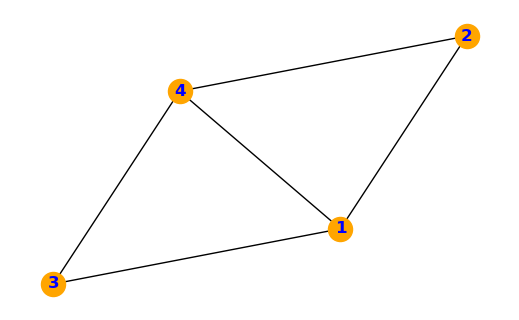

In [2]:
# First generate the simulation network
plt.figure(figsize=(5, 3))

# Define edges
edges = [(1,2), (1,3), (1,4), (2,4), (3,4)]

# Create graph and add edges
G = nx.Graph()
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='black', font_color='blue', font_weight='bold')
plt.show()

Parameter fitting for filtered 47 stocks that starting from 2015.

In [3]:
raw_tickers = [
    'NVDA', 'TSLA', 'INTC', 'LCID', 'SOFI', 'F', 'PLTR', 'AAL', 'MRVL', 'QBTS',
    'RIOT', 'AMD', 'PCG', 'OSCR', 'WBD', 'AAPL', 'AMZN', 'QUBT', 'HIMS', 'SMCI',
    'BAC', 'PFE', 'MARA', 'COIN', 'ACHR', 'HOOD', 'GOOG', 'CLF', 'AVGO', 'RGTI',
    'GOOGL', 'APLD', 'HL', 'T', 'SNAP', 'AUR', 'CLSK', 'UBER', 'HBAN', 'WFC',
    'SOUN', 'GNW', 'AGNC', 'MRK', 'CSCO', 'ASTS', 'PYPL', 'JOBY', 'MU', 'CCL',
    'MP', 'VZ', 'RKLB', 'IONQ', 'LYFT', 'XOM', 'MSFT', 'SLB', 'AES', 'QXO',
    'ADT', 'CMCSA', 'RIVN', 'KO', 'HAL', 'BMY', 'PTEN', 'OXY', 'PTON', 'ORCL',
    'V', 'OKLO', 'C', 'ENPH', 'NKE'
]

# 1) Download everything in one DataFrame with a multi-level column index
# This tends to be faster and more consistent than looping Ticker.history()
raw = yf.download(
    raw_tickers,
    start="1900-01-01",  # far past to force max history
    end=pd.Timestamp.today().strftime("%Y-%m-%d"),
    group_by="ticker",
    threads=True,
    progress=False,
)

cutoff = pd.Timestamp("2014-12-31")
tickers = []

for t in raw_tickers:
    try:
        # Some tickers may not appear in raw.columns if invalid/delisted
        if t not in raw:
            print(f"{t}: no data at all")
            continue

        df = raw[t].dropna(subset=["Close"])  # use Close to detect actual trading rows
        if df.empty:
            print(f"{t}: empty history")
            continue

        first_date = df.index.min()
        print(f"{t}: first bar on {first_date.date()}")
        if first_date <= cutoff:
            tickers.append(t)

    except Exception as e:
        print(f"{t}: error {e!r}")

print("\nTickers with history starting on or before 2014-12-31:")
print(tickers)
print(f'Total {len(tickers)} tickers.')

C:\Users\Brian\AppData\Local\Temp\ipykernel_8976\2902984934.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(


NVDA: first bar on 1999-01-22
TSLA: first bar on 2010-06-29
INTC: first bar on 1980-03-17
LCID: first bar on 2020-09-18
SOFI: first bar on 2021-01-04
F: first bar on 1972-06-01
PLTR: first bar on 2020-09-30
AAL: first bar on 2005-09-27
MRVL: first bar on 2000-06-30
QBTS: first bar on 2020-12-11
RIOT: first bar on 2016-03-31
AMD: first bar on 1980-03-17
PCG: first bar on 1972-06-01
OSCR: first bar on 2021-03-03
WBD: first bar on 2005-07-08
AAPL: first bar on 1980-12-12
AMZN: first bar on 1997-05-15
QUBT: first bar on 2007-02-01
HIMS: first bar on 2019-09-13
SMCI: first bar on 2007-03-29
BAC: first bar on 1973-02-21
PFE: first bar on 1972-06-01
MARA: first bar on 2012-05-04
COIN: first bar on 2021-04-14
ACHR: first bar on 2020-12-18
HOOD: first bar on 2021-07-29
GOOG: first bar on 2004-08-19
CLF: first bar on 1973-02-21
AVGO: first bar on 2009-08-06
RGTI: first bar on 2021-04-22
GOOGL: first bar on 2004-08-19
APLD: first bar on 2022-04-13
HL: first bar on 1980-03-17
T: first bar on 1983-

In [4]:
# Fetch daily closing prices
# period: most recent 10 years
data = yf.download(
    tickers=tickers,
    start='2015-01-01',
    end='2025-01-01',
    interval='1d',
    group_by='ticker'
)

# Create clean DataFrame
closing_prices = pd.DataFrame({
    t: data[t]['Close'] for t in tickers
}).dropna()

C:\Users\Brian\AppData\Local\Temp\ipykernel_8976\1997962291.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  47 of 47 completed


In [5]:
# Calculate the daily log returns (trade working days)
log_returns = np.log(closing_prices).diff().dropna()
log_returns  # Show first 5 rows

,NVDA,TSLA,INTC,F,AAL,MRVL,AMD,PCG,WBD,AAPL,...,KO,HAL,BMY,PTEN,OXY,ORCL,V,C,ENPH,NKE
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.017034,-0.042950,-0.011341,-0.039846,-0.000557,-0.016667,-0.003752,0.016732,-0.042055,-0.028576,...,0.000000,-0.019950,-0.015751,-0.054300,-0.037779,-0.014123,-0.022321,-0.032022,-0.023497,-0.016231
2015-01-06,-0.030788,0.005648,-0.018813,-0.009531,-0.015713,0.037792,-0.011342,-0.001476,-0.033213,0.000094,...,0.007565,-0.009865,-0.001709,-0.033530,-0.008535,-0.010377,-0.006464,-0.035839,-0.070126,-0.005899
2015-01-07,-0.002609,-0.001563,0.020758,0.028323,-0.000566,0.014061,-0.019195,0.007908,0.007166,0.013925,...,0.012405,0.026517,0.012912,-0.036052,0.000130,0.000232,0.013309,0.009227,-0.126710,0.020446
2015-01-08,0.036927,-0.001566,0.018430,0.024952,0.012187,0.063125,0.011561,0.012560,0.008040,0.037703,...,0.012023,0.021366,0.024676,0.002716,0.008791,0.006007,0.013323,0.014936,0.028536,0.022821
2015-01-09,0.004020,-0.018981,0.001906,-0.013712,-0.031040,0.000624,0.007634,0.009900,-0.013644,0.001072,...,-0.011093,-0.010249,-0.006610,-0.004076,-0.001933,-0.000461,-0.014934,-0.022586,-0.017197,-0.011085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.070991,0.009852,0.012048,0.005780,0.019068,0.013472,0.011440,0.010481,0.011413,...,0.007347,0.021846,0.003121,0.021053,0.005836,0.013332,0.010755,0.017476,0.003828,0.000391
2024-12-26,-0.002070,-0.017787,0.001959,0.004978,0.000000,-0.002072,-0.009787,-0.000495,0.006613,0.003171,...,-0.004306,-0.001491,0.004147,0.018065,0.001661,0.001574,0.000811,0.004918,-0.003691,0.001952
2024-12-27,-0.021088,-0.050745,-0.006873,-0.003980,0.000000,-0.018228,0.001039,-0.003470,-0.000942,-0.013331,...,-0.001920,-0.000373,-0.005533,0.003829,0.007441,-0.015970,-0.007036,-0.004918,-0.012126,-0.006782


In [6]:
def average_corr_computation(df, quantile_val):
    """
    Compute the average daily correlation matrix (one correlation matrix per calendar day), 
    and the threshold at the given quantile of off-diagonal absolute average CoC values.
    
    Args:
        df (pd.DataFrame): the pd.DataFrame contains the time series data of shape (T,d), T for time steps and d for number of nodes.
        quantile_val (float): a float between 0 and 1 for determining the threshold based on quantiles.
    
    Returns:
        average_coc_mat (np.ndarray): the averaged CoC matrix by taking the average of the sum of CoC matrix for each trading day.
        threshold (float): the threshold value for building the edge between nodes.
    """
    
    df = df.sort_index()  # make sure our df is sorted by time
    
    # Group by calendar month
    months = df.index.to_period('M')
    grouped = df.groupby(months)
    d = df.shape[1]  # number of nodes/stocks
    total_corr_mat = np.zeros((d, d))  # initialise the total corr matrix
    valid_months = 0  # Count of months with valid data
    
    for month, month_data in grouped:
        # Skip months with insufficient data, we need at least two observations for each month
        if len(month_data) < 2:
            continue
            
        # Check for constant columns (zero variance)
        std_devs = month_data.std()
        if (std_devs == 0).any():
            continue
            
        # Compute correlation matrix
        corr_mat = np.corrcoef(month_data.values, rowvar=False)
        corr_mat = abs(corr_mat)  # take the absolute value of corr values showing how close but no sign-direction
        total_corr_mat += corr_mat
        valid_months += 1  # update valid months count
    
    # Handle case with no valid months
    if valid_months == 0:
        average_corr_mat = np.full((d, d), np.nan)  # give a NaN matrix if no valid months
        threshold = np.nan  # no threshold if no valid months
    else:
        # Since averaging would not change the quantile, it is absolutely fine if we just keep total_coc_mat
        # but statistically speaking we may still prefer using the averaged one over all trading days
        average_corr_mat = total_corr_mat / valid_months
        # Extract off-diagonal upper triangle CoC values (as absolute values)
        off_diag_vals = average_corr_mat[np.triu_indices(d, k=1)]
        threshold = np.quantile(off_diag_vals, quantile_val)  # set the threshold to be chosen quantile
    
    return average_corr_mat, threshold

In [7]:
def coc_network_construction(df, quantile_val):
    """Return the network constructed by CoC.

    Args:
        df (pd.DataFrame): the pd.DataFrame contains the time series data of shape (T,d), T for time steps and d for number of nodes.
        quantile_val (float): a float between 0 and 1 for determining the threshold based on quantiles.
    """
    # First compute the average_coc_mat and threshold via defined function above
    average_corr_mat, threshold = average_corr_computation(df, quantile_val)
    
    # 1) Initialise an empty undirected graph
    G = nx.Graph()
    labels = df.columns.tolist()

    # 2) Add all tickers as nodes
    G.add_nodes_from(labels)

    # 3) Add an (unweighted) edge whenever |CoC| > threshold
    d = average_corr_mat.shape[0]
    for i, j in combinations(range(d), 2):
        if abs(average_corr_mat[i, j]) > threshold:
            G.add_edge(labels[i], labels[j])

    # 4) Visualise with a spring‐layout
    pos = nx.spring_layout(G, k=1.5, seed=0)
    plt.figure(figsize=(16, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='orange', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='blue', font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(
        f'Unweighted GNGARCH correlation Network\n(|corr| > {threshold:.4f}, {quantile_val*100:.0f}% quantile)',
        fontsize=20
    )
    plt.axis("off")
    
    # 5) Compute the store the adjacency matrix for this network
    A = nx.to_numpy_array(G, nodelist=labels, dtype=int)
    
    return A, G

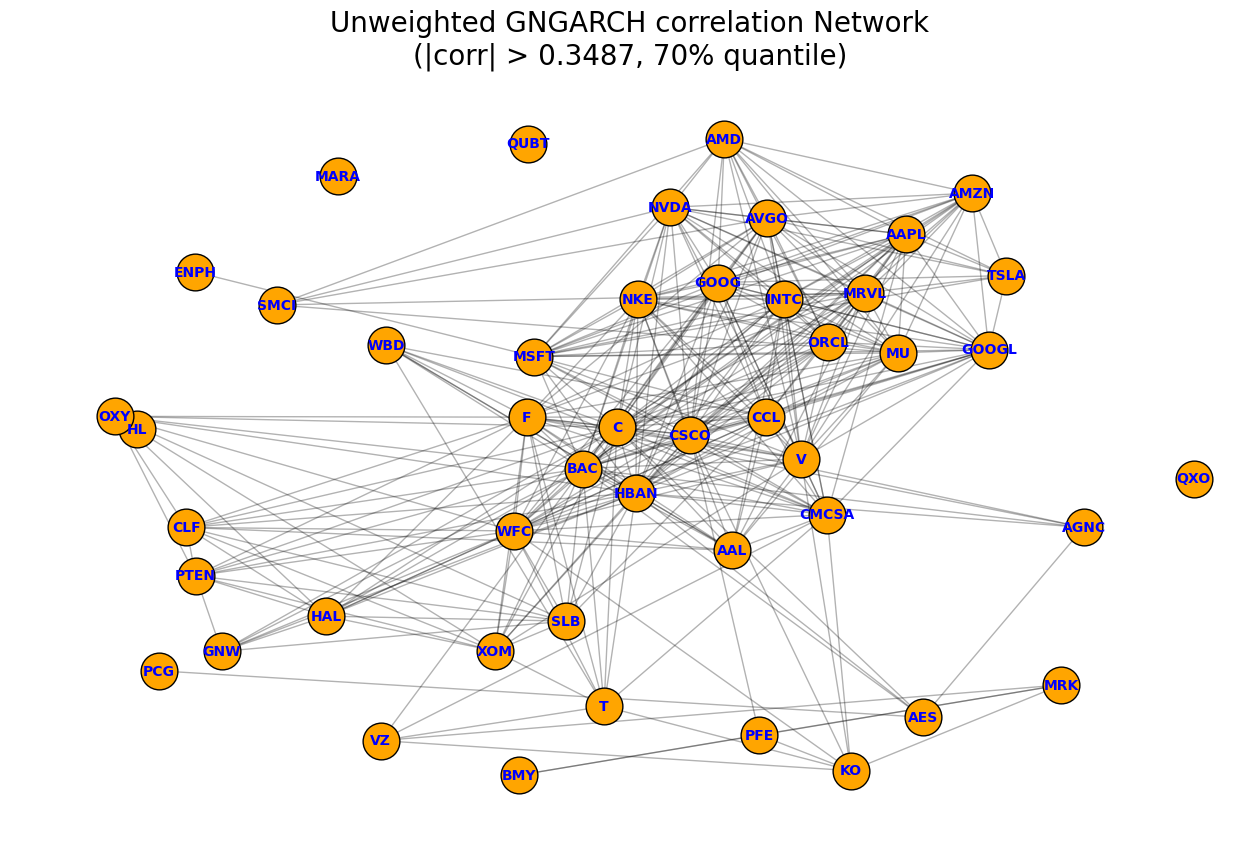

In [8]:
A, G = coc_network_construction(log_returns, quantile_val=0.7)

In [9]:
def r_stage_node_weight_matrix(G, r):
    """
    Compute the r-stage neighbourhood node weight matrix W^(r) for a network G.
    See the definition of r-stage node weight matrix in the paper.

    Args:
        G (nx.Graph): An unweighted undirected graph.
        r (int): The neighbourhood order (distance) to consider.

    Returns:
        W (np.ndarray): The row-normalized weight matrix for r-stage neighbours. Nodes are ordered according to G.nodes().
    """
    
    nodes = sorted(list(G.nodes()))  # correct ascending order
    d = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    W = np.zeros((d, d), dtype=float)

    # Precompute all shortest‐path lengths up to distance r
    spl = dict(nx.all_pairs_shortest_path_length(G, cutoff=r))

    for i, u in enumerate(nodes):
        # Find r‐stage neighbours
        neigh_r = [v for v, d in spl.get(u, {}).items() if d == r]
        if not neigh_r:
            # if no r‐neighbours, skip (all zeros in that row)
            continue
        # Fetch tilde‐weights
        tilde = []
        for v in neigh_r:
            data = G.get_edge_data(u, v) or {}
            tilde_w = data.get('weight', 1.0)
            tilde.append(tilde_w)

        tilde = np.array(tilde, dtype=float)
        total = tilde.sum()
        if total == 0:
            # Equal weights (unweighted network)
            weights = np.ones_like(tilde) / len(tilde)
        else:
            # Weighted network
            weights = tilde / total

        # Fill row i in W
        for v, w in zip(neigh_r, weights):
            j = idx[v]
            W[i, j] = w

    return W

In [10]:
def node_weight_matrix(G):
    """Generate the total node weight matrix W, as the sum of all non-zero r-stage node weight matrices.

    Args:
        G (nx.Graph): An unweighted undirected graph.
    Returns:
        W_total (np.ndarray): The overall node weight matrix for the network G. 
    """
    
    nodes = list(G.nodes())
    d = len(nodes)
    # Initialise the total node weight matrix W_total
    W_total = np.zeros((d, d), dtype=float)
    
    # Initialise r=1 for the first stage node weight matrix
    r = 1
    
    while True:
        W_r = r_stage_node_weight_matrix(G, r)
        # If W_r has no non-zero entries (all entries are zero), break
        # this can be done by using np.any OR logic gate
        if not np.any(W_r):
            break
        # Otherwise accumulate and move to next r
        W_total += W_r
        r += 1

    return W_total

In [11]:
W_tot = np.zeros((len(tickers), len(tickers)))

for r in range(1, 7):
    print(f'Is the {r}-stage node weight matrix a zero matrix?', np.all(r_stage_node_weight_matrix(G, r) == np.zeros((len(tickers), len(tickers)))))
    W_tot += r_stage_node_weight_matrix(G, r)
    
W_total = node_weight_matrix(G)

# Since we already achieve zero matrix for r > 6, then we expect W_tot == W_total to show our function is valid
np.all(W_tot == W_total)

Is the 1-stage node weight matrix a zero matrix? False
Is the 2-stage node weight matrix a zero matrix? False
Is the 3-stage node weight matrix a zero matrix? False
Is the 4-stage node weight matrix a zero matrix? False
Is the 5-stage node weight matrix a zero matrix? False
Is the 6-stage node weight matrix a zero matrix? True


True

---

In [12]:
# Center the log-returns
log_returns -= log_returns.mean()
log_returns_data = log_returns.to_numpy()
log_returns.head()

,NVDA,TSLA,INTC,F,AAL,MRVL,AMD,PCG,WBD,AAPL,...,KO,HAL,BMY,PTEN,OXY,ORCL,V,C,ENPH,NKE
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.019272,-0.044270,-0.011209,-0.039877,-0.000129,-0.017515,-0.005268,0.017081,-0.041585,-0.029503,...,-0.000282,-0.019874,-0.015852,-0.054087,-0.037707,-0.014711,-0.022970,-0.032232,-0.024123,-0.016462
2015-01-06,-0.033025,0.004329,-0.018681,-0.009562,-0.015285,0.036945,-0.012858,-0.001127,-0.032743,-0.000833,...,0.007283,-0.009789,-0.001810,-0.033316,-0.008463,-0.010966,-0.007113,-0.036049,-0.070752,-0.006130
2015-01-07,-0.004847,-0.002883,0.020889,0.028292,-0.000138,0.013213,-0.020710,0.008258,0.007636,0.012998,...,0.012124,0.026593,0.012811,-0.035838,0.000201,-0.000356,0.012660,0.009018,-0.127336,0.020215
2015-01-08,0.034690,-0.002885,0.018561,0.024921,0.012615,0.062277,0.010045,0.012910,0.008510,0.036776,...,0.011742,0.021442,0.024575,0.002930,0.008863,0.005419,0.012674,0.014726,0.027910,0.022591
2015-01-09,0.001782,-0.020300,0.002037,-0.013743,-0.030612,-0.000223,0.006118,0.010250,-0.013174,0.000145,...,-0.011375,-0.010172,-0.006711,-0.003862,-0.001861,-0.001049,-0.015583,-0.022796,-0.017824,-0.011316


In [13]:
class GNGARCH(nn.Module):
    def __init__(self, d, W, S, device, init_params=None):
        super().__init__()
        self.d = d
        self.device = device
        
        # Compute W_s and create neighbour mask
        W_s = W * S
        self.register_buffer('W_s', W_s)
        
        # Initialize trainable log-parameters
        if init_params is None:
            init_vals = torch.tensor([0.1, 0.3, 0.4, 0.1, 0.1], 
                                    dtype=torch.float32, device=device)
            init_params = torch.log(init_vals)
        self.params = nn.Parameter(init_params)

    def get_params(self):
        """Return constrained (positive) parameters"""
        alpha0, alpha1, gamma1, beta11, delta11 = torch.exp(self.params)
        return alpha0, alpha1, gamma1, beta11, delta11
    
    @staticmethod
    def compute_B_t(X_t):
        """Compute and return matrix B_t, PyTorch version."""
        B_t = torch.outer(X_t, X_t)
        B_t.fill_diagonal_(0.0)  # we can directly use fill_diagonal_ in PyTorch when it is just a number
        return B_t
    
    @staticmethod
    def compute_D_t(cov_t):
        """Compute and return matrix D_t, PyTorch version."""
        D_t = cov_t.clone()
        D_t.fill_diagonal_(0.0)
        return D_t

    def ensure_posdef(self, cov_mat):
        """
        Ensure covariance matrix is positive definite and not ill-conditioned by adding jitter, 
        so we can use Cholesky decomposition.
        """
        # Compute the eigenvalues and check if the matrix is positive definite
        min_eigval = torch.min(torch.linalg.eigvalsh(cov_mat))
        jitter = torch.zeros_like(cov_mat)  # initialise jitter to zero
        # Set a threshold for jitter, ensuring PD and not ill-conditioned 
        # this value is normally 1e-3 or 1e-4, as even smaller thresholds may lead slow convergence (still ill-conditioned)
        # a big threshold may perturb the covariance matrix too much
        threshold = 1e-3
        # If the minimum eigenvalue is less than threshold, we need to add jitter to ensure PD
        if min_eigval < threshold:
            jitter = (-min_eigval + threshold) * torch.eye(self.d, device=self.device)
        
        cov_mat += jitter  # Add jitter to the covariance matrix
        return cov_mat

    def compute_conditional(self, X_prev, var_prev, cov_prev):
        """Vectorised computation with proper exclusions"""
        alpha0, alpha1, gamma1, beta11, delta11 = self.get_params()
        d = self.d
        
        # 1. Vectorised variance update
        clustering_term = beta11 * (self.W_s @ (X_prev ** 2))
        persistence_term = delta11 * (self.W_s @ var_prev)
        var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term + persistence_term
        
        # 2. Vectorised covariance update
        # Base GARCH component
        base_cov = alpha0 + alpha1 * torch.outer(X_prev, X_prev) + gamma1 * cov_prev
        
        # Neighbouring clustering effect using vectorisation
        compute_B_prev = self.compute_B_t(X_prev)
        clustering_i_neighbour = self.W_s @ compute_B_prev
        clustering_j_neighbour = compute_B_prev @ self.W_s.T
        clustering_neighbour = 0.5 * beta11 * (clustering_i_neighbour + clustering_j_neighbour)
        
        # Neighbouring persistence effect using vectorisation
        compute_D_prev = self.compute_D_t(cov_prev)
        persistence_i_neighbour = self.W_s @ compute_D_prev
        persistence_j_neighbour = compute_D_prev @ self.W_s.T
        persistence_neighbour = 0.5 * delta11 * (persistence_i_neighbour + persistence_j_neighbour)
        
        # Combine components, both based part and neighbouring part
        cov_curr = base_cov + clustering_neighbour + persistence_neighbour
        cov_curr[range(d), range(d)] = var_curr  # Set diagonal
        cov_curr = self.ensure_posdef(cov_curr)  # Ensure positive definiteness
        
        return var_curr, cov_curr
    
    def nll_loss(self, X_data, var0, cov0):
        """
        Compute the negative Log-Likelihood loss, which is proportional to QLIKE (invariant to a constant),
        assumes conditional multivariate normal distribution (needed for QLIKE).
        """
        
        T, d = X_data.shape
        total_nll = 0.0

        var_prev, cov_prev = var0.clone(), cov0.clone()
        const = d * torch.log(2 * torch.tensor(torch.pi, device=self.device))

        for t in range(1, T):
            X_prev, X_curr = X_data[t-1], X_data[t]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = torch.linalg.cholesky(cov_curr)

            # Compute the log-determinant term using Cholesky decomposition L
            log_det = 2.0 * torch.sum(torch.log(torch.diag(L)))
            
            # Compute the quadratic form: X_curr^T * inv(Sigma) * X_curr
            inv_cov_curr = torch.cholesky_inverse(L)
            quad = X_curr @ (inv_cov_curr @ X_curr)
            total_nll += 0.5 * (const + log_det + quad)
            
            # Update previous values for next iteration
            var_prev, cov_prev = var_curr, cov_curr

        return total_nll / (T - 1)
    
    # An alternative loss function that computes the MSE
    def mse_loss(self, X_data, var0, cov0):
        """
        Vectorized MSE loss computation, comparing conditional covariance with observed squared returns.
        """
        
        T, d = X_data.shape
        total_mse = 0.0
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            # Compute observed covariance proxy (squared returns)
            obs_cov = torch.outer(X_data[t], X_data[t])
            # Vectorised MSE
            total_mse += torch.mean((cov_curr - obs_cov) ** 2)
            
            # Update state
            var_prev = var_curr
            cov_prev = cov_curr
        return total_mse / (T - 1)
    
    def forward(self, X_data, var0, cov0):
        T, d = X_data.shape
        X_sim = torch.zeros_like(X_data)
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        X_sim[0] = X_data[0]
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = self.ensure_posdef_cholesky(cov_curr)
            
            Z = torch.randn(d, device=self.device)
            X_sim[t] = L @ Z
            # Update the previous values for the next iteration
            var_prev = var_curr
            cov_prev = cov_curr
        return X_sim

In [14]:
def train(n_epochs, model, data, var0, cov0, method, optimizer):
    loss_history = []
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        if method in ('nll', 'qlike'):
            loss = model.nll_loss(data, var0, cov0)
        elif method == 'mse':
            loss = model.mse_loss(data, var0, cov0)
        else:
            raise ValueError('Method must be either nll/qlike or mse.')
        # Store the loss for plotting
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {method} loss = {loss.item():.4f}')
            
    # Extract fitted parameters
    with torch.no_grad():
        alpha0, alpha1, gamma1, beta11, delta11 = model.get_params()
    print(f'Fitted parameters via {method}:')
    print(f'alpha0 = {alpha0.item():.4f}')
    print(f'alpha1 = {alpha1.item():.4f}')
    print(f'gamma1 = {gamma1.item():.4f}')
    print(f'beta11 = {beta11.item():.4f}')
    print(f'delta11 = {delta11.item():.4f}')
    
    return loss_history

In [15]:
# Prepare the data & network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GNGARCH_data_torch = torch.tensor(log_returns_data, dtype=torch.float32).to(device)  # shape (T, d)
T, d = GNGARCH_data_torch.shape
W_torch = torch.tensor(W_total, dtype=torch.float32).to(device)  # shape (d, d)
S1_torch = torch.tensor(A, dtype=torch.float32).to(device)  # shape (d, d)

# Initial states
var0 = torch.ones(d, dtype=torch.float32).to(device)  # initial variances
cov0 = torch.eye(d, dtype=torch.float32).to(device)  # initial covariances (identity matrix)

# Instantiate model + optimizer
model = GNGARCH(d=d, W=W_torch, S=S1_torch, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
# Train the model with different losses
mse_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='mse', optimizer=optimizer)
nll_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='nll', optimizer=optimizer)

Epoch 100: mse loss = 0.0057
Epoch 200: mse loss = 0.0028
Epoch 300: mse loss = 0.0018
Epoch 400: mse loss = 0.0013
Epoch 500: mse loss = 0.0010
Fitted parameters via mse:
alpha0 = 0.0228
alpha1 = 0.0699
gamma1 = 0.1660
beta11 = 0.0229
delta11 = 0.0423
Epoch 100: nll loss = -95.4938
Epoch 200: nll loss = -97.5946
Epoch 300: nll loss = -98.5076
Epoch 400: nll loss = -99.0373
Epoch 500: nll loss = -99.3789
Fitted parameters via nll:
alpha0 = 0.0003
alpha1 = 0.1401
gamma1 = 0.7626
beta11 = 0.0003
delta11 = 0.0026
